In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Анализ и прогнозирование временных рядов методами искусственного интеллекта

### **Практическая работа 3. Поиск аномалий во временных рядах.**


#### **3.1 Поиск диссонансов с помощью алгоритма HotSAX**

In [29]:
!pip install saxpy

##### *Краткое описание*

##### 3.1.1 Загрузка и подготовка данных

В данной будет использоваться временной ряд, состоящий из показаний акселерометра.
Анализируемый временной ряд, описывает две активности человека - бег и шг
.


In [30]:
import numpy as np
from saxpy.znorm import znorm
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from time import time

In [31]:
#fixme: Путь
data_path = Path('/content/drive/MyDrive/2023-Petrushenko-TimeSeriesCourse/practice/03 Discords/dataset')/'walk_run.txt'
data = np.loadtxt(data_path)[3000:4000]
size_sub = 50

В середине временного ряда происходит смена активности (бег заменяет шаг). Нетипичным поведением, которое мы могли бы назвать диссонансами в данном ряде выступает небольшой участок между активностями, когда человек плавно увеличивает скорость шага до бега. В ходе данной работе наша задача выделить с помощью различных алгоритмов границы нашего диссонанса.

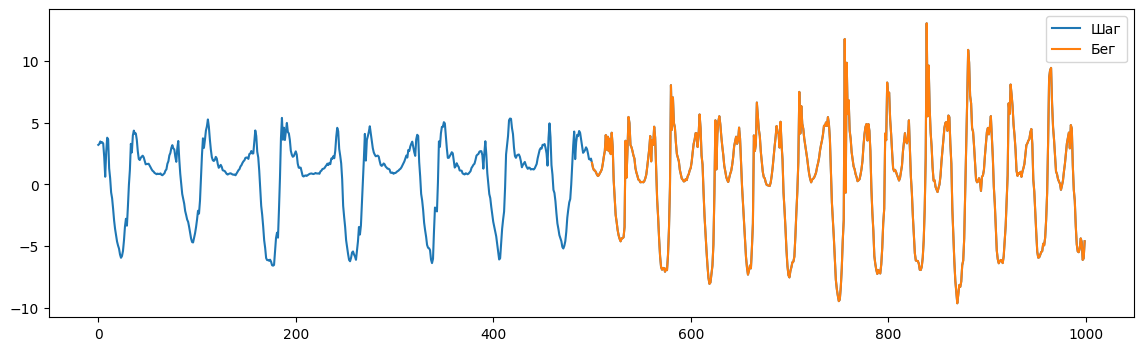

In [32]:
fig, ax =  plt.subplots(figsize=(14, 4), ncols=1, nrows=1)
plt.plot(data[:], label='Шаг')
plt.plot(np.arange(data.shape[0] // 2, data.shape[0]), data[data.shape[0] // 2:], label='Бег')
plt.legend()

In [33]:
result={}
times={}

##### 3.1.2 Реализация перебором

Приводится пример кода для нахождения топ-5 диссонансов с помощью реализация перебором.
Вам необходимо добавить код для сбора времени обработки данных.

In [34]:
from saxpy.discord import find_discords_brute_force

start = time()
discords_brute_force = np.stack(find_discords_brute_force(data, 50, 5))
end = time()
result['brute_force'] = discords_brute_force
times['brute_force'] = end - start

##### 3.1.3 HotSAX

Используя [реализацию](https://github.com/seninp/saxpy/blob/master/saxpy/hotsax.py) найдите топ 5 диссонансов ряда.
Произведите замер времени работы.

In [35]:
from saxpy.hotsax import find_discords_hotsax

start = time()
discords_hotsax = np.stack(find_discords_hotsax(data, 50, 5))
end = time()
result['hotsax'] = discords_hotsax
times['hotsax'] = end - start

##### 3.1.4 Визаулизация

Вам необходимо реализовать код позволяющий:
1. Вывести на одном графике ряд и его диссонансы;
2. Столбчатую диаграмму времени работы.
   
Постройте графики для обоих алгоритмов и сравните полученные результаты. Сделайте выводы

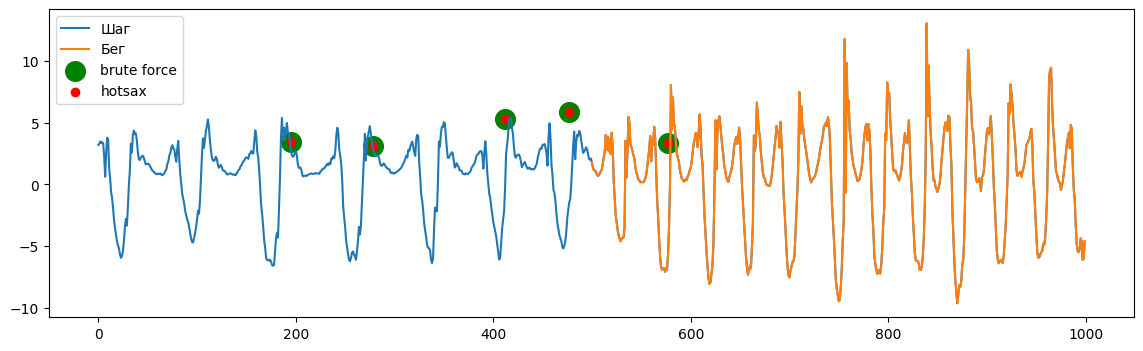

In [44]:
fig, ax =  plt.subplots(figsize=(14, 4), ncols=1, nrows=1)
plt.plot(data[:], label='Шаг')
plt.plot(np.arange(data.shape[0] // 2, data.shape[0]), data[data.shape[0] // 2:], label='Бег')
plt.scatter(discords_brute_force[:, 0], discords_brute_force[:, 1], s=200, color='green', label='brute force')
plt.scatter(discords_hotsax[:, 0], discords_hotsax[:, 1], color='red', label='hotsax')
plt.legend()

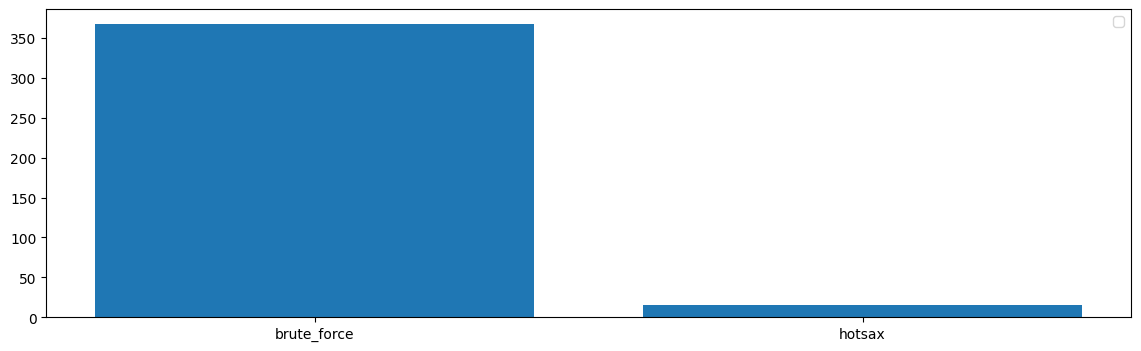

In [46]:
fig, ax =  plt.subplots(figsize=(14, 4), ncols=1, nrows=1)
plt.bar(times.keys(), times.values())
plt.legend()

Вывод: ...

#### **3.2 Поиск диссонансов с помощью алгоритма DRAG**

In [39]:
!pip install stumpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.1/169.1 kB 2.7 MB/s eta 0:00:00


In [40]:
import pandas as pd
import stumpy
from stumpy import core, config
from stumpy.scrump import _prescrump
import numpy as np
import matplotlib.pyplot as plt
import math
import time


Диапазонный диссонанс – подпоследовательность ряда, расстояние от которой до ее ближайшего соседа не ниже заданного порога.

Таким образом при поиске основными параметрами данного алгоритма являются:
- $m$ - длина диссонанса
- $r$ - пороговое значение расстояния подпоследовательности ряда, до его ближайшего сдаосе

Установим пока что эти параметры случайным образом.а.


In [41]:
from modules.drag import find_candidates
m = 100
r = 4.7

ModuleNotFoundError: ignored

##### 3.2.1 Отбор кандидатов

Первым этапом обработки данных является отбор множества потенциальных кандидатов. Мы вибраем из всего множества подпоследовательностей ряда такие, для которых растояния до правых ближайших соседей больше параметра $r$.

In [ ]:
T, M_T, Σ_T = core.preprocess(data, m)
is_cands = find_candidates(T, m, M_T, Σ_T, r, init_cands=None, right=True)
cand_index = np.flatnonzero(is_cands)

In [ ]:
len(cand_index)/len(data)*100

Во время отбора кандидатов нам удалось выделить около 140 подпоследовательностей(около 14%), которые мы бы могли назвать потенциальными диссонансами.
Это большой процент, который не может нас устраивать как конечный результат.
Если посмотреть на рисунок ниже, мы увидем, что большая часть потенциальных диссонансов расположена в районе смены активности.
К сожалению присуствуют и ложные диссонасы, которые случаныйм образом попали в данный список.

In [ ]:
fig, ax =  plt.subplots(figsize=(14,4),ncols=1,nrows=1)
plt.plot(data[:],label='Шаг')
plt.plot(np.arange(data.shape[0]//2,data.shape[0]),data[data.shape[0]//2:],label='Бег')
max_ = np.max(data[:])
min_ = np.min(data[:])
for indx, discord in enumerate(cand_index):
    ax.add_patch(Rectangle((discord,min_),m,
                            max_+np.abs(min_),
                                                    color='red',
                                                    alpha=0.1))
plt.legend()


##### 3.2.2 Очистка кандидатов
Как уже упоминалось выше, 14% слишком большой процент диссонансов.
Для уменьшения числа потенциальных кандидатов произведем очистку от ложных диссонансов, путем сравнения расстояния до левых ближайших соседей потенциальных диссонансов с числом $r$.


In [ ]:
is_cands = find_candidates(T, m, M_T, Σ_T, r, init_cands=is_cands, right=False)
cands = np.flatnonzero(is_cands)

In [ ]:
len(cands)/len(data)*100

In [ ]:
fig, ax =  plt.subplots(figsize=(14,4),ncols=1,nrows=1)
plt.plot(data[:],label='Шаг')
plt.plot(np.arange(data.shape[0]//2,data.shape[0]),data[data.shape[0]//2:],label='Бег')
max_ = np.max(data[:])
min_ = np.min(data[:])
for indx, discord in enumerate(cands):
    ax.add_patch(Rectangle((discord,min_),m,
                            max_+np.abs(min_),
                                                    color='red',
                                                    alpha=0.1))
plt.legend()


Нам удалось сократить число диссонансов до 7%. Если проанализировать рисунок, то можно заметить, что большая их часть является тривиальными повторениями подпоследовательности в области смены активности. На следующем шаге избавимся от них.

In [ ]:
from modules.drag import refine_candidates
discords_idx, discords_dist, discords_nn_idx = refine_candidates(T, m, M_T, Σ_T, is_cands)
len(discords_idx)/len(data)*100

In [ ]:
fig, ax =  plt.subplots(figsize=(14,4),ncols=1,nrows=1)
plt.plot(data[:],label='Шаг')
plt.plot(np.arange(data.shape[0]//2,data.shape[0]),data[data.shape[0]//2:],label='Бег')
max_ = np.max(data[:])
min_ = np.min(data[:])
for indx, discord in enumerate(discords_idx):
    ax.add_patch(Rectangle((discord,min_),m,
                            max_+np.abs(min_),
                                                    color='red',
                                                    alpha=0.25))
plt.legend()


##### 3.2.3 Подбор параметров

Подберите параметры $m$ и $r$ таким образом, чтобы алгоритм обнаружил только те диссонасы, которые связаны со сменой активности.
Попробуйте несколько различных комбинаций $m$ и $r$. Сделайте вывод о том, как эти параметры влияют на качество работы модели.

#### **2.3 Поиск диссонансов с помощью алгоритма Merlin**

##### *Краткое описание*

##### 2.3.1 Загрузка и подготовка данных
fixme: добавить описание данных и саму выгрузку данных

##### 2.3.2 Merlin

Используя [реализацию]() найдите топ 5 диссонансов ряда.
Произведите замер времени работы. (уточнить про реализацию поиска соседей)

##### 2.3.3 Визаулизация

Вам необходимо реализовать код позволяющий:
1. Вывести на одном графике ряд и его диссонансы
2. Графики времени работы
   
Постройте графики для моделей и сравните полученные результаты с алгоритмами из предыдущих пунктов.
Сделайте выводы